# eq_PR_bias: Zonal structure of time-mean PR in the equatorial Pacific


Computes the zonal root mean square error (RMSE) of equatorial Pacific (150°E-90°W) climatological (time and meridional 5°S-5°N average) precipitation (PR) between model and observations


## Datasets and reanalysis used for comparison

The following reference observational datasets are used to evaluate the model simulations:

- **GPCPv2.3 (1979-2018)**: The primary dataset for comparison. The Global Precipitation Climatology Project (GPCP) combines satellite and surface precipitation measurements to provide comprehensive global precipitation data.
  
Additional observational datasets used for comparison include:
- **20CRv2 (1871-2012)**: The 20th Century Reanalysis provides global atmospheric data, including precipitation, based on surface pressure observations and ensemble assimilation techniques.
- **CMAP (1979-2018)**: The CPC Merged Analysis of Precipitation (CMAP) is a blend of gauge and satellite observations, offering global precipitation estimates.
- **ERA-Interim (1979-2018)**: Reanalysis data produced by the European Centre for Medium-Range Weather Forecasts (ECMWF), providing atmospheric variables, including precipitation, based on a large-scale model and historical observations.
- **NCEP2 (1979-2018)**: The second generation of the National Centers for Environmental Prediction (NCEP) reanalysis, offering precipitation and other atmospheric variables.

## Dask Cluster 

Start a cluster with multiple cores 

In [2]:
from dask.distributed import Client, progress
client = Client()
client

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.06/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36503 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/36503/status,
Dashboard: /proxy/36503/status,Workers: 4
Total threads: 12,Total memory: 95.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35657,Workers: 0
Dashboard: /proxy/36503/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:39459,Total threads: 3
Dashboard: /proxy/42467/status,Memory: 23.75 GiB
Nanny: tcp://127.0.0.1:39683,


## Datasets

In [3]:
from esmvalcore.dataset import Dataset

In [4]:
model_datasets = {
"ACCESS-ESM1-5": 
    Dataset(
    short_name='pr',
    project='CMIP6',
    mip="Amon",
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="19790101/20150101",
    dataset="ACCESS-ESM1-5",
    grid="gn"
)}

obs_datasets = {
"GPCP-SG": 
    Dataset(
    short_name='pr',
    dataset='GPCP-SG',
    mip="Amon",
    project='OBS',
    type='atmos',
    tier=2),
# "NOAA-CIRES-20CR-V2": 
#     Dataset(
#     short_name='pr',
#     dataset='NOAA-CIRES-20CR-V2',
#     mip="Amon",
#     project='OBS6',
#     type='reanaly',
#     timerange="187101/201212",
#     tier=2),
# "CMAP": 
#     Dataset(
#     short_name='pr',
#     dataset='CMAP',
#     mip="Amon",
#     project='OBS6',
#     type='reanaly',
#     timerange="197901/202408",
#     tier=2),
## ERA-Interim not available in Tier2. Conctact NRI
# "ERA-Interim": 
#     Dataset(
#     short_name='pr',
#     dataset='ERA-Interim',
#     mip="Amon",
#     project='OBS6',
#     type='reanaly',
#     timerange="19790101/20190101",
#     tier=3)
}

## Add Ancillary files

In [5]:
for name, dataset in model_datasets.items():
    dataset.add_supplementary(short_name='sftlf', mip="fx")
    dataset.add_supplementary(short_name="areacella", mip="fx")

In [6]:
model_datasets = {name: dataset.load() for name, dataset in model_datasets.items()}
obs_datasets = {name: dataset.load() for name, dataset in obs_datasets.items()}

(for file /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/fx/sftlf/gn/v20191115/sftlf_fx_ACCESS-ESM1-5_historical_r1i1p1f1_gn.nc)


In [7]:
model_datasets

{'ACCESS-ESM1-5': <iris 'Cube' of precipitation_flux / (kg m-2 s-1) (time: 432; latitude: 145; longitude: 192)>}

## Pre-processors

In [8]:
from esmvalcore.preprocessor import annual_statistics
from esmvalcore.preprocessor import climate_statistics
from esmvalcore.preprocessor import convert_units
from esmvalcore.preprocessor import extract_region
from esmvalcore.preprocessor import extract_time
from esmvalcore.preprocessor import regrid
from esmvalcore.preprocessor import axis_statistics
from esmvalcore.preprocessor import mask_landsea

In [9]:
def preproc1(cube):
    equatorial_pacific_region = {"start_longitude": 150., "end_longitude": 270., "start_latitude": -5., "end_latitude": 5.}
    cube = extract_time(cube, start_year=1979, start_month=1, start_day=1, end_year=2014, end_month=12, end_day=31)
    cube = convert_units(cube, units="mm/day")
    cube = mask_landsea(cube, mask_out="land")
    cube = climate_statistics(cube, operator="mean", period="full")
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = extract_region(cube, **equatorial_pacific_region)
    cube = axis_statistics(cube, operator="mean", axis="y")
    return cube

def preproc2(cube):
    equatorial_pacific_region = {"start_longitude": 150., "end_longitude": 270., "start_latitude": -15., "end_latitude": 15.}
    cube = extract_time(cube, start_year=1979, start_month=1, start_day=1, end_year=2014, end_month=12, end_day=31)
    cube = convert_units(cube, units="mm/day")
    cube = mask_landsea(cube, mask_out="land")
    cube = climate_statistics(cube, operator="mean", period="full")
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = extract_region(cube, **equatorial_pacific_region)
    return cube

def preproc3(cube):
    equatorial_pacific_region = {"start_longitude": 150., "end_longitude": 270., "start_latitude": -15., "end_latitude": 15.}
    cube = extract_time(cube, start_year=1979, start_month=1, start_day=1, end_year=2014, end_month=12, end_day=31)
    cube = convert_units(cube, units="mm/day")
    cube = mask_landsea(cube, mask_out="land")
    cube = climate_statistics(cube, operator="mean", period="full")
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    #cube = extract_region(cube, **equatorial_pacific_region)
    return cube

In [10]:
model_datasets_prep1 = {name: preproc1(dataset) for name, dataset in model_datasets.items()}
obs_datasets_prep1 = {name: preproc1(dataset) for name, dataset in obs_datasets.items()}

model_datasets_prep2 = {name: preproc2(dataset) for name, dataset in model_datasets.items()}
obs_datasets_prep2 = {name: preproc2(dataset) for name, dataset in obs_datasets.items()}

model_datasets_prep3 = {name: preproc3(dataset) for name, dataset in model_datasets.items()}
obs_datasets_prep3 = {name: preproc3(dataset) for name, dataset in obs_datasets.items()}

# Diagnostics Level 1


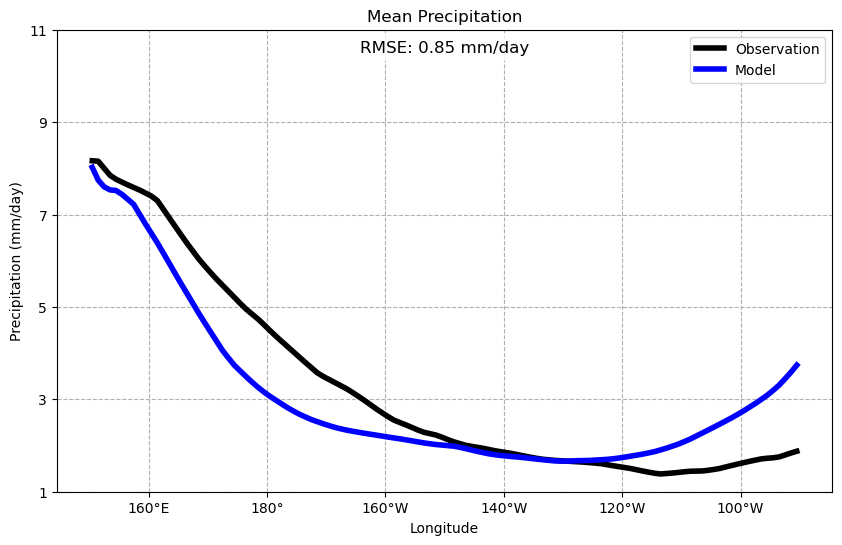

In [11]:
import iris
import iris.quickplot as qplt
import matplotlib.pyplot as plt
import numpy as np

# Function to format x-axis labels with degree symbols and N/S
def format_longitude(x, pos):
    if x > 180:
        return f'{int(360 - x)}°W'
    elif x == 180:
        return f'{int(x)}°'
    else:
        return f'{int(x)}°E'

plt.figure(figsize=(10, 6))

obs_data = obs_datasets_prep1["GPCP-SG"]
model_data = model_datasets_prep1["ACCESS-ESM1-5"]

# Plot observation data in black
qplt.plot(obs_data, color='black', label='Observation', linewidth=4)

# Plot model data in blue
qplt.plot(model_data, color='blue', label='Model', linewidth=4)

rmse = np.sqrt(np.mean((obs_data.data - model_data.data) ** 2))

# Adding labels and title
plt.xlabel('Longitude')
plt.ylabel('Precipitation (mm/day)')
plt.title('Mean Precipitation')
plt.grid(linestyle='--')
plt.yticks(np.arange(1,12, step=2))

# Adding RMSE text on top of the plot
plt.text(0.5, 0.95, f'RMSE: {rmse:.2f} mm/day', fontsize=12, ha='center', transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# Setting custom x-axis formatter
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_longitude))

# Adding a legend
plt.legend()

# Display the plot
plt.show()

Figure 1: Zonal bias in the time-mean precipitation (PR) structure across the equatorial Pacific (averaged between 5°S–5°N), illustrating the increased precipitation in the eastern Pacific and decreased precipitation in the western Pacific. The black curve represents the reference data, while the blue curve represents the model data. The metric shown is the zonal RMSE between the model and reference curves.

# Diagnostics Level 2


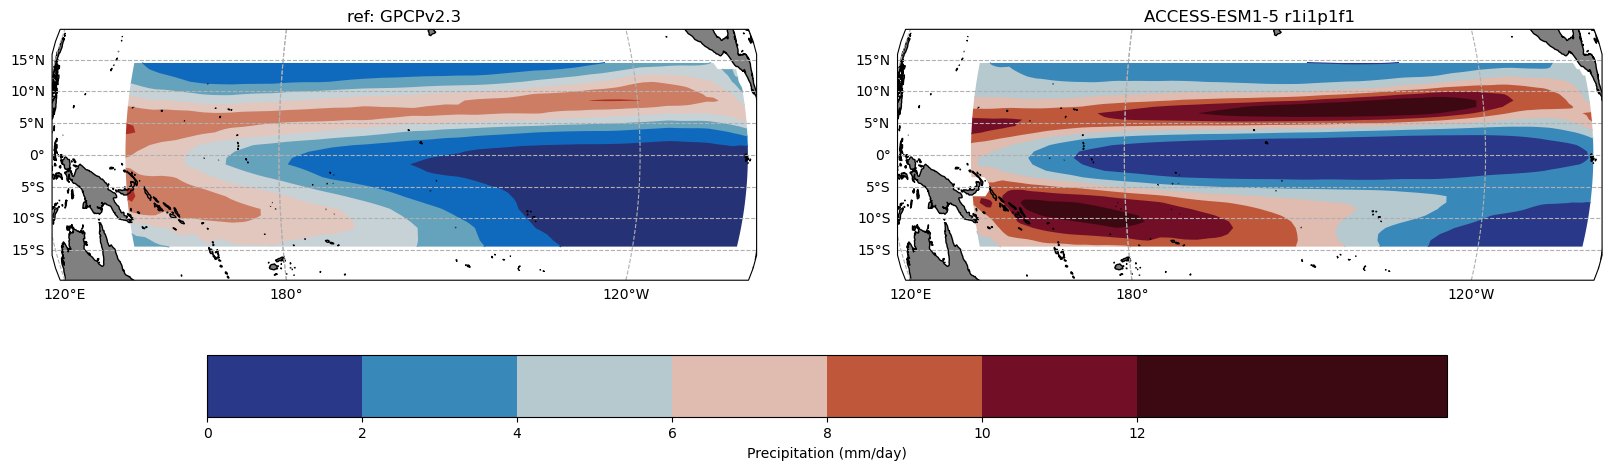

In [12]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as mcolors
import cmocean

# Importing numpy for linear space creation
import numpy as np

import iris
import iris.plot as iplt

obs_data = obs_datasets_prep2["GPCP-SG"]
model_data = model_datasets_prep2["ACCESS-ESM1-5"]

# Create a colormap from cmocean balance
cmap = cmocean.cm.balance
colors = cmap(np.linspace(0, 1, 14))

# Create a large figure
fig = plt.figure(figsize=(20, 10))  # Adjusted for full width

# Center the map on the Pacific Ocean (roughly around 180° longitude)
proj = ccrs.Orthographic(central_longitude=-160, central_latitude=0)

# Define the normalization for the color scale with range of 0 to 12 mm
norm = mcolors.Normalize(vmin=0, vmax=12)

# Plot #1: contourf with axes longitude from -180 to 180
ax1 = plt.subplot(121, projection=proj)
cf1 = iplt.contourf(obs_data, cmap=cmap, norm=norm)
ax1.add_feature(cfeature.LAND, facecolor='gray')  # Add land feature with gray color
ax1.coastlines()
ax1.set_extent([120, -80, -20, 20], crs=ccrs.PlateCarree())
ax1.set_title("ref: GPCPv2.3")

# Add gridlines for latitude and longitude
gl1 = ax1.gridlines(draw_labels=True, linestyle='--')
gl1.top_labels = False
gl1.right_labels = False

# Plot #2: contourf with axes longitude from 0 to 360
ax2 = plt.subplot(122, projection=proj)
cf2 = iplt.contourf(model_data, cmap=cmap, norm=norm)
ax2.add_feature(cfeature.LAND, facecolor='gray')  # Add land feature with gray color
ax2.coastlines()
ax2.set_extent([120, -80, -20, 20], crs=ccrs.PlateCarree())
ax2.set_title("ACCESS-ESM1-5 r1i1p1f1")

# Add gridlines for latitude and longitude
gl2 = ax2.gridlines(draw_labels=True, linestyle='--')
gl2.top_labels = False
gl2.right_labels = False

# Add a single colorbar at the bottom
cbar = fig.colorbar(cf2, ax=[ax1, ax2], orientation='horizontal', pad=0.15, shrink=0.8)
cbar.set_label('Precipitation (mm/day)')
cbar.set_ticks(np.arange(0, 13, 2))  # Set ticks at intervals of 2 mm

plt.subplots_adjust(bottom=0.3)  # Further adjust bottom margin to fit the colorbar
plt.show()


Figure 2: Time-mean precipitation (PR) bias in the equatorial Pacific, primarily highlighting the double intertropical convergence zone (ITCZ) bias. The reference data is shown on the left map, and the model data on the right.

In [13]:
# 3d visualization

import accessvis
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import os
import pandas as pd
import os
import xarray as xr
import lavavu

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as mcolors
import cmocean
from skimage.transform import resize

from tqdm import tqdm
from scipy.ndimage import gaussian_filter

In [14]:
obs_data = obs_datasets_prep2["GPCP-SG"]
model_data = model_datasets_prep2["ACCESS-ESM1-5"]

print(model_data.shape)

def generate_rgba(data, cmap, vmin, vmax):
    data = model_data.data  # 2D numpy array
    lon = model_data.coord('longitude').points
    lat = model_data.coord('latitude').points
    
    lon2d, lat2d = np.meshgrid(lon, lat)
    
    # cmap = cmocean.cm.balance
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    
    fig, ax = plt.subplots(figsize=(6, 3), dpi=100)
    cf = ax.contourf(lon2d, lat2d, data, cmap=cmap, norm=norm, levels=20)
    ax.axis('off')
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)

    fig.canvas.draw()
    rgba = np.frombuffer(fig.canvas.tostring_argb(), dtype=np.uint8)
    rgba = rgba.reshape(fig.canvas.get_width_height()[::-1] + (4,))  # (H, W, 4)

    rgba = rgba[:, :, [1, 2, 3, 0]]
    plt.close(fig)
    return rgba

def resize_rgba(data, width, height):
    #If the original image is of type uint8, it needs to be converted to float32 before resizing.
    rgba_float = rgba.astype(np.float32) / 255.0

    # Resize the image (while preserving the number of channels).
    rgba_resized = resize(rgba_float, (width, height, 4), preserve_range=True, anti_aliasing=True)
    
    # change back to uint8
    rgba_resized = np.clip(rgba_resized * 255, 0, 255).astype(np.uint8)

    return rgba_resized

def pad_rgba(data, pad_width,pad_height,pad_depth=None,constant_values=255):
    if pad_depth:
        padded_rgba = np.pad(
                    data,
                    pad_width=(pad_width, pad_height, pad_depth),
                    mode='constant',
                    constant_values=constant_values
        )
    else:
         padded_rgba = np.pad(
                    data,
                    pad_width=(pad_width, pad_height),
                    mode='constant',
                    constant_values=constant_values 
        )
    return padded_rgba

def normalise_array(values, minimum=None, maximum=None):
    """
    Normalize an array to the range [0,1]

    Parameters
    ----------
    values : numpy.ndarray
        Values to convert, numpy array
    minimum: number
        Use a fixed minimum bound, default is to use the data minimum
    maximum: number
        Use a fixed maximum bound, default is to use the data maximum
    """

    # Ignore nan when getting min/max
    if not minimum:
        minimum = np.nanmin(values)
    if not maximum:
        maximum = np.nanmax(values)

    # Normalise
    array = (values - minimum) / (maximum - minimum)
    # Clip out of [0,1] range - in case defined range is not the global minima/maxima
    array = np.clip(array, 0, 1)

    return array

def opacity_rgba(padded_array, opacity_array):
    array = normalise_array(opacity_array)
    oarray = array
    oarray = np.nan_to_num(oarray)
    oarray = (oarray * 255).astype(np.uint8)
    padded_array[::, ::, 3] = oarray
    return padded_array

(30, 120)


In [15]:
cmap = cmocean.cm.balance

rgba=generate_rgba(model_data.data, cmap = cmap, vmin=0, vmax=12)
resized_rgba=resize_rgba(rgba,width=150,height=600)
padded_rgba=pad_rgba(resized_rgba,pad_width=(375, 375),pad_height=(750, 450),pad_depth=(0, 0))
opacity_array = resize(model_data.data, (150, 600), order=1, preserve_range=True, anti_aliasing=True)
padded_opacity_array=pad_rgba(opacity_array,pad_width=(375, 375),pad_height=(750, 450),constant_values=0)
opacitied_rgba=opacity_rgba(padded_rgba, padded_opacity_array)

lv = accessvis.plot_earth(texture='bluemarble', background="white", vertical_exaggeration=20)
lv.rotation(15.0, -180.0, 0.0) #Rotate to Australia
lv.set_properties(diffuse=0.8, ambient=0.1, specular=0.35, shininess=0.03, light=[1,1,0.98]) # make pretty
lv.brightness_contrast_saturation(0.5, 0.5, 0.65)
accessvis.update_earth_values(lv, dataMode=0, data=opacitied_rgba)

cbar=lv.colourbar(size=[0.95,15], align="bottom", tickvalues=[2,4,6,8,10,12])
cbar.colourmap('coolwarm', range=[0,14])

lv.title("ACCESS-ESM1-5")
lv.window(resolution=(700,700))

In [16]:
cmap = cmocean.cm.balance

rgba=generate_rgba(model_data.data, cmap = cmap, vmin=0, vmax=12)
resized_rgba=resize_rgba(rgba,width=150,height=600)
padded_rgba=pad_rgba(resized_rgba,pad_width=(375, 375),pad_height=(750, 450),pad_depth=(0, 0))
opacity_array = resize(model_data.data, (150, 600), order=1, preserve_range=True, anti_aliasing=True)
padded_opacity_array=pad_rgba(opacity_array,pad_width=(375, 375),pad_height=(750, 450),constant_values=0)
opacitied_rgba=opacity_rgba(padded_rgba, padded_opacity_array)

lv = accessvis.plot_earth(texture='bluemarble', background="white", vertical_exaggeration=20)
lv.rotation(15.0, -180.0, 0.0) #Rotate to Australia
lv.set_properties(diffuse=0.8, ambient=0.1, specular=0.35, shininess=0.03, light=[1,1,0.98]) # make pretty
lv.brightness_contrast_saturation(0.5, 0.5, 0.65)
accessvis.update_earth_values(lv, dataMode=0, data=opacitied_rgba)

cbar=lv.colourbar(size=[0.95,15], align="bottom", tickvalues=[2,4,6,8,10,12])
cbar.colourmap('coolwarm', range=[0,14])

lv.title("GPCP-SG")
lv.window(resolution=(700,700))

In [23]:
class Visualization():
    """
    A class to generate, process, and render visualizations of geospatial data using contour plots and Lavavu.

    This class supports generating RGBA images from geospatial data, applying resizing and padding,
    handling opacity layers, and displaying results in Lavavu either as a contour field or smoothed gradient.

    Attributes:
        data (iris.cube.Cube): Input geospatial data (2D).
        size (tuple): Desired image size as (width, height).
        lat_range (tuple): Latitude range to display (min_lat, max_lat).
        lon_range (tuple): Longitude range to display (min_lon, max_lon).
        title (str): Title of the visualization.
        colormap (str or callable): Colormap used for the visualization.
        tickvalues (list): Tick values to show on colorbar.
        vmax (float): Maximum value for normalization.
        vmin (float): Minimum value for normalization.
        resolution (tuple, optional): Output resolution of the Lavavu window. Default is (700, 700).

    Methods:
        generate_rgba(): Generate RGBA image from the input data using matplotlib.
        resize_rgba(rgba, width, height): Resize an RGBA image to given dimensions.
        pad_rgba(data, pad_width, pad_height, pad_depth=None, constant_values=255): Pad an RGBA or data array.
        opacity_rgba(padded_array, opacity_array): Apply opacity to the alpha channel of an RGBA image.
        generate_lv(): Set up and configure the Lavavu Earth visualization.
        calculate_pad(): Compute the padding sizes based on latitude and longitude ranges.
        visualise_contourf(window=False): Generate and display contour visualization in Lavavu.
        visualise_gradient(window=False): Generate and display a smoothed gradient visualization in Lavavu.
    """

    
    def __init__(self, data, size, lat_range, lon_range, title, colormap, tickvalues, vmax, vmin, resolution=(700, 700)):
        self.data = data
        self.size = size
        self.width = size[0]
        self.height = size[1]
        self.title = title
        self.colormap = colormap
        self.tickvalues = tickvalues
        self.lat_range = lat_range
        self.lon_range = lon_range
        self.resolution =  resolution
        self.vmax = vmax
        self.vmin = vmin

    def generate_rgba(self):
        data = self.data.data  # 2D numpy array
        lon = self.data.coord('longitude').points
        lat = self.data.coord('latitude').points
        
        lon2d, lat2d = np.meshgrid(lon, lat)
        
        cmap = cmocean.cm.balance
        norm = mcolors.Normalize(vmin=self.vmin, vmax=self.vmax)
        
        fig, ax = plt.subplots(figsize=(6, 3), dpi=100)
        cf = ax.contourf(lon2d, lat2d, data, cmap=cmap, norm=norm, levels=20)
        ax.axis('off')
        fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
    
        fig.canvas.draw()
        rgba = np.frombuffer(fig.canvas.tostring_argb(), dtype=np.uint8)
        rgba = rgba.reshape(fig.canvas.get_width_height()[::-1] + (4,))  # (H, W, 4)
    
        rgba = rgba[:, :, [1, 2, 3, 0]]
        plt.close(fig)
        
        return rgba

    def resize_rgba(self, rgba, width, height):
        #If the original image is of type uint8, it needs to be converted to float32 before resizing.
        rgba_float = rgba.astype(np.float32) / 255.0
    
        # Resize the image (while preserving the number of channels).
        rgba_resized = resize(rgba_float, (width, height, 4), preserve_range=True, anti_aliasing=True)
        
        # change back to uint8
        rgba_resized = np.clip(rgba_resized * 255, 0, 255).astype(np.uint8)
    
        return rgba_resized
        
    def pad_rgba(self, data, pad_width, pad_height, pad_depth=None, constant_values=255):
        if pad_depth:
            padded_rgba = np.pad(
                        data,
                        pad_width=(pad_width, pad_height, pad_depth),
                        mode='constant',
                        constant_values=constant_values 
            )
        else:
             padded_rgba = np.pad(
                        data,
                        pad_width=(pad_width, pad_height),  
                        mode='constant',
                        constant_values=constant_values  
            )
            
        return padded_rgba

    def opacity_rgba(self, padded_array, opacity_array):
        array = normalise_array(opacity_array)
        oarray = array
        oarray = np.nan_to_num(oarray)
        oarray = (oarray * 255).astype(np.uint8)
        padded_array[::, ::, 3] = oarray
        
        return padded_array

    def generate_lv(self):
        lv = accessvis.plot_earth(texture='bluemarble', background="white", vertical_exaggeration=20)
        lv.rotation(15.0, -200.0, 0.0) #Rotate to Pacific
        lv.set_properties(diffuse=0.8, ambient=0.1, specular=0.35, shininess=0.03, light=[1,1,0.98]) # make pretty
        lv.brightness_contrast_saturation(0.5, 0.5, 0.65)

        cbar=lv.colourbar(size=[0.95,15], align="bottom", tickvalues=self.tickvalues)
        cbar.colourmap(self.colormap, range=[self.vmin,self.vmax])
        lv.title(self.title)
        
        return lv

    def calculate_pad(self):
        self.pad_width = ((self.lat_range[0]-(-90))*5, (90-self.lat_range[1])*5)
        self.pad_height = (self.lon_range[0]*5, (360 - self.lon_range[1])*5)

    def visualise_contourf(self, window=False):
        self.calculate_pad()
        rgba=self.generate_rgba()
        resized_rgba=self.resize_rgba(rgba,width=self.width,height=self.height)
        padded_rgba=self.pad_rgba(resized_rgba,pad_width=self.pad_width,pad_height=self.pad_height,pad_depth=(0, 0))
        opacity_array = resize(self.data.data, self.size, order=1, preserve_range=True, anti_aliasing=True)
        padded_opacity_array=self.pad_rgba(opacity_array,pad_width=self.pad_width,pad_height=self.pad_height,constant_values=0)
        opacitied_rgba=self.opacity_rgba(padded_rgba, padded_opacity_array)

        lv = self.generate_lv()
        accessvis.update_earth_values(lv, dataMode=0, data=opacitied_rgba)

        if window:
            lv.window(resolution=self.resolution)
        else:
            lv.display(resolution=self.resolution)

    def visualise_gradient(self, window=False):
        lv = self.generate_lv()

        pad_width = ((self.lat_range[0]-(-90)), (90-self.lat_range[1]))
        pad_height = (self.lon_range[0], (360 - self.lon_range[1]))

        padded_data = np.pad(self.data.data, pad_width=(pad_width, pad_height), mode='constant', constant_values=0)

        smoothed = gaussian_filter(padded_data, sigma=1.0)
        colours_model = accessvis.array_to_rgba(smoothed, flip=True, colourmap=self.colormap, opacitymap=True, minimum=self.vmin, maximum=self.vmax)
        accessvis.update_earth_values(lv, dataMode=0, data=colours_model)
        if window:
            lv.window(resolution=self.resolution)
        else:
            lv.display(resolution=self.resolution)

In [18]:
obs_data = obs_datasets_prep2["GPCP-SG"]
model_data = model_datasets_prep2["ACCESS-ESM1-5"]

v_model = Visualization(data=model_data, size=(150,600), lat_range=(-15, 15), lon_range=(150, 270), title="ACCESS-ESM1-5", colormap="coolwarm", tickvalues=[2,4,6,8,10,12], vmax=12, vmin=0)
v_obs = Visualization(data=obs_data, size=(150,600), lat_range=(-15, 15), lon_range=(150, 270), title="GPCP-SG", colormap="coolwarm", tickvalues=[2,4,6,8,10,12], vmax=12, vmin=0)


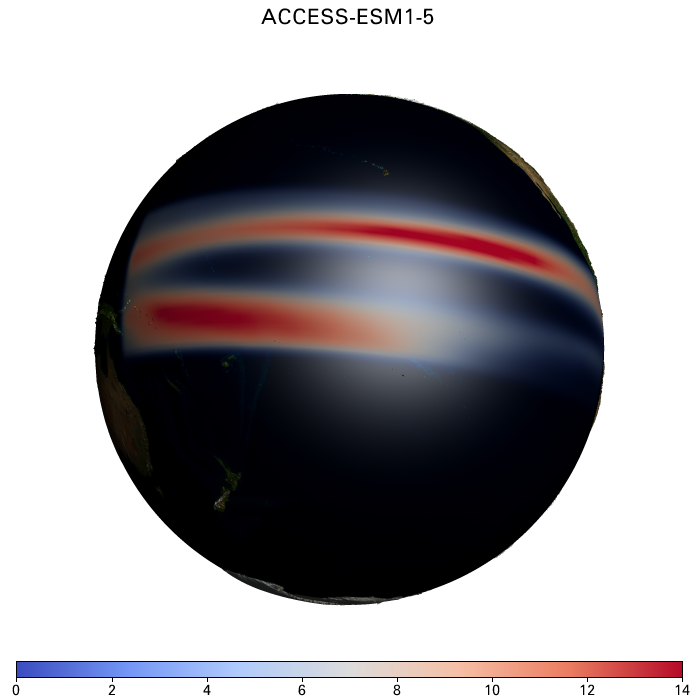

In [19]:
# specify window=True if you would like an interactive window
v_model.visualise_gradient()


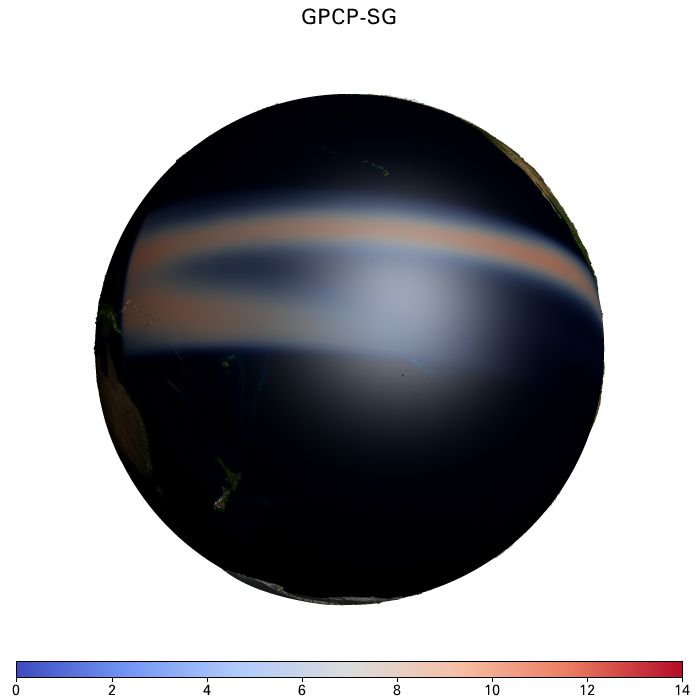

In [20]:
# specify window=True if you would like an interactive window
v_obs.visualise_gradient()


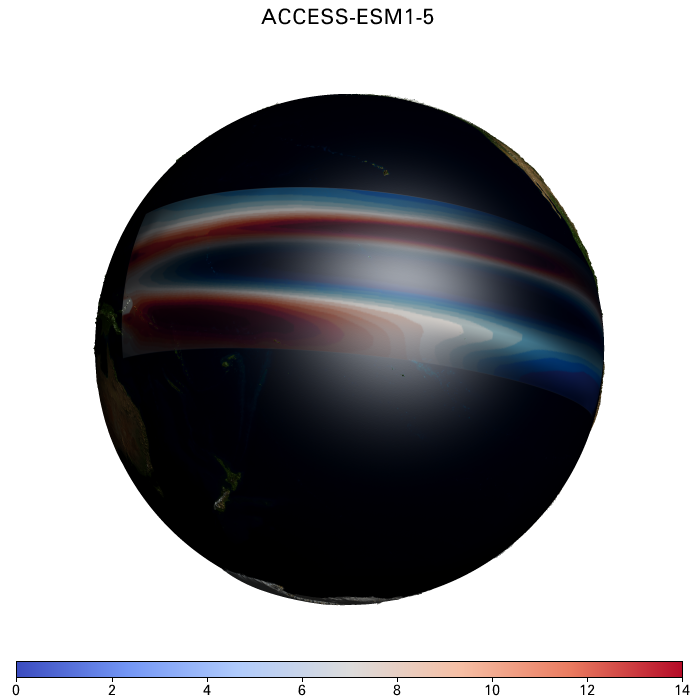

In [21]:
# specify window=True if you would like an interactive window
v_model.visualise_contourf()


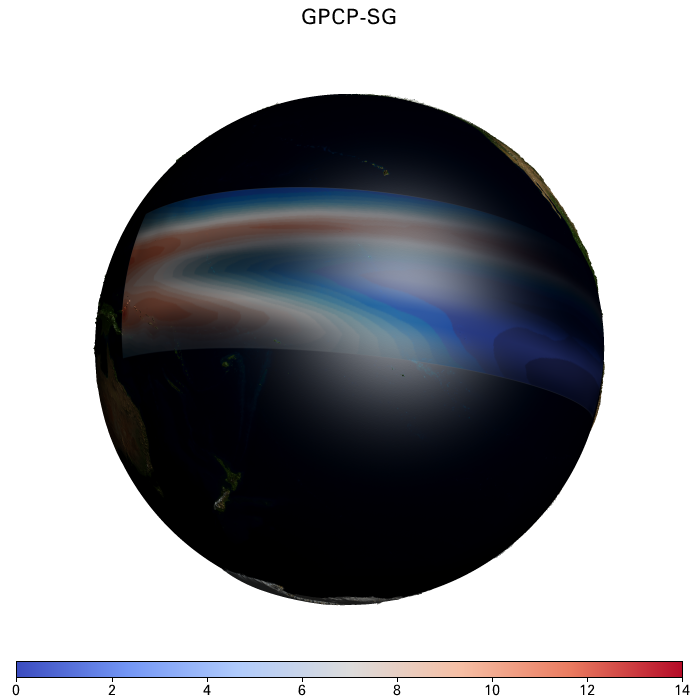

In [22]:
# specify window=True if you would like an interactive window
v_obs.visualise_contourf()